In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
data = pd.read_csv("./dataset/cleaned_news_summary.csv")
data.head()

,Unnamed: 0,author,date,headlines,read_more,text,ctext,cleaned_text,cleaned_headline
0,0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...,administration union territory daman diu revok...,daman diu revokes mandatory rakshabandhan in o...
1,1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo...",malaika arora slammed instagram user trolled d...,malaika slams user who trolled her for divorci...
2,2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...,indira gandhi institute medical sciences igims...,virgin now corrected to unmarried in igims form
3,3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,lashkaretaibas kashmir commander abu dujana ki...,aaj aapne pakad liya let man dujana before bei...
4,4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...,hotels maharashtra train staff spot signs sex ...,hotel staff to get training to spot signs of s...


In [9]:
news = data.cleaned_text
headline = data.cleaned_headline
news_len = []
headline_len = []
for obj in range(len(news)):
    news_len.append(len(news[obj].split()))
    headline_len.append(len(headline[obj].split()))

Text(0.5, 1.0, 'Distribution of length of news text')

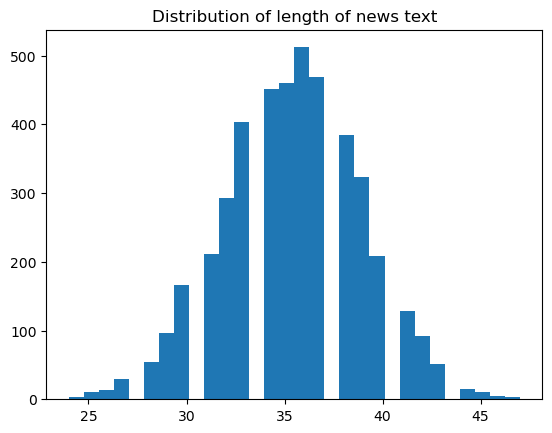

In [10]:
plt.hist(news_len, bins=30)
plt.title("Distribution of length of news text")

Text(0.5, 1.0, 'Distribution of length of headline text')

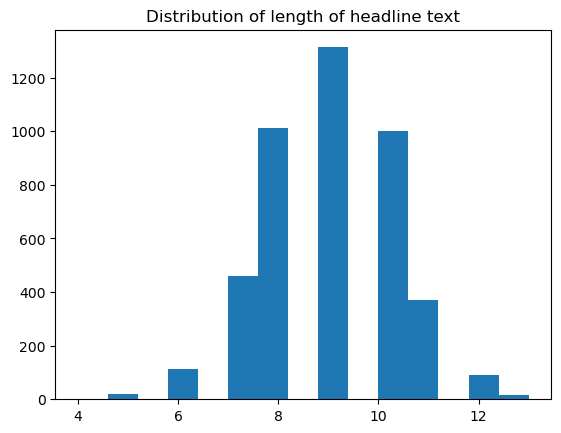

In [11]:
plt.hist(headline_len, bins=15)
plt.title("Distribution of length of headline text")

In [12]:
max_len_news = 50
max_len_headline = 13

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.cleaned_text, data.cleaned_headline, test_size=0.2, random_state=101, shuffle=True)

In [33]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [34]:
X_train

742     new airport project navi mumbai take away 250 ...
1776    according reports actor shahid kapoor admitted...
24      two sunbathers 56yearold man eightyearold girl...
3383    election commission said thursday hold open ha...
2674    panchayat village rajasthan issued order prohi...
                              ...                        
4079    eminent economist heinz kurz said demonetisati...
4171    manipur saturday witnessed hung assembly congr...
599     south delhi municipal corporation proposed con...
1361    tanika dhara 23yearold nationallevel swimmer w...
1547    many five localities central delhi including j...
Name: cleaned_text, Length: 3516, dtype: object

In [35]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))
X_train = X_tokenizer.texts_to_sequences(X_train)
X_test = X_tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen = max_len_news, padding='post')
X_test = pad_sequences(X_test, maxlen = max_len_news, padding='post')

news_vocab_size = len(X_tokenizer.word_index) + 1

In [36]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train = y_tokenizer.texts_to_sequences(y_train)
y_test = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train, maxlen=max_len_headline, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_headline, padding='post')